# Random forests with monotonic constraints

This notebook shows how ow to use XGBoost's random forest mode in order to produce random forests with monotonic constraints.

To illustrate, we use a data set of information on 20'000 houses
from Kings County, see below.

## Unconstrained model

In [2]:
%load_ext lab_black

In [1]:
# Imports
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRFRegressor

# Fetch data from OpenML
df = fetch_openml(data_id=42092, as_frame=True)["frame"]
print("Shape: ", df.shape)
df.head()

Shape:  (21613, 20)


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,20141013T000000,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178,47.5112,-122.257,1340.0,5650.0
1,20141209T000000,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125,47.7210,-122.319,1690.0,7639.0
2,20150225T000000,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028,47.7379,-122.233,2720.0,8062.0
3,20141209T000000,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136,47.5208,-122.393,1360.0,5000.0
4,20150218T000000,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074,47.6168,-122.045,1800.0,7503.0


In [3]:
# Prepare data
df = df.assign(
    year=lambda x: x.date.str[0:4].astype(int),
    zipcode=lambda x: x.zipcode.astype(int),
    log_sqft_lot=lambda x: np.log(x.sqft_lot),
    building_age=lambda x: x.year - x.yr_built,
)

# Feature list
xvars = [
    "grade",
    "year",
    "building_age",
    "sqft_living",
    "log_sqft_lot",
    "bedrooms",
    "bathrooms",
    "floors",
    "zipcode",
    "lat",
    "long",
    "condition",
    "waterfront",
]

# Data split
y_train, y_test, X_train, X_test = train_test_split(
    np.log(df["price"]), df[xvars], train_size=0.8, random_state=766
)

In [5]:
# Model
param_dict = dict(
    n_estimators=500,
    max_depth=20,
    learning_rate=1,
    subsample=0.63,
    colsample_bynode=1 / 3,
    reg_lambda=0,
    objective="reg:squarederror",
    min_child_weight=2,
)

unconstrained = XGBRFRegressor(**param_dict).fit(X_train, y_train)

# Test RMSE 0.176
pred = unconstrained.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, pred, squared=False):.03f}")

RMSE: 0.176


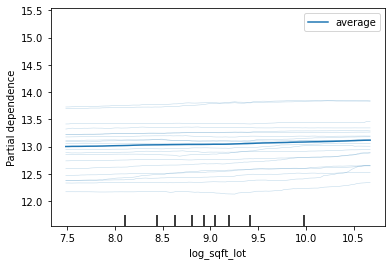

In [6]:
# ICE and PDP
from sklearn.inspection import PartialDependenceDisplay

PartialDependenceDisplay.from_estimator(
    unconstrained,
    X=X_train,
    features=["log_sqft_lot"],
    kind="both",
    subsample=20,
    random_state=1,
)

## Constrained model

In [7]:
# One needs to pass the constraints as single string, which is rather ugly
mc = "(" + ",".join([str(int(x == "log_sqft_lot")) for x in xvars]) + ")"
print(mc)

# Model
constrained = XGBRFRegressor(monotone_constraints=mc, **param_dict)
constrained.fit(X_train, y_train)

# Test RMSE: 0.178
pred = constrained.predict(X_test)
print(f"RMSE: {mean_squared_error(y_test, pred, squared=False):.03f}")

(0,0,0,0,1,0,0,0,0,0,0,0,0)
RMSE: 0.178


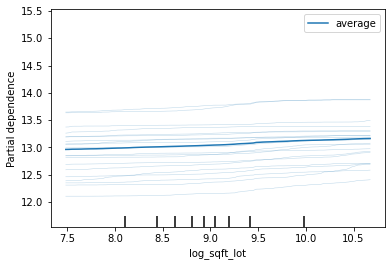

In [8]:
# ICE
PartialDependenceDisplay.from_estimator(
    constrained,
    X=X_train,
    features=["log_sqft_lot"],
    kind="both",
    subsample=20,
    random_state=1,
)